In [1]:
import numpy as np
import zarr
import os
from skimage import io
import hashlib
import matplotlib.pyplot as plt 

In [2]:
def create_lut(labels):
    labels = labels.astype(np.int64)  # ensure labels are integer
    max_label = np.max(labels)

    lut = np.zeros((int(max_label + 1), 4), dtype=np.uint8)
    lut[:, 3] = 255  # alpha channel

    for label in range(1, int(max_label + 1)):
        # Generate a deterministic RGB color based on label
        md5 = hashlib.md5()
        md5.update(str(label).encode('utf-8'))
        color_hash = md5.hexdigest()
        lut[label, :3] = [int(color_hash[i:i+2], 16) for i in (0, 2, 4)]

    colored_labels = lut[labels]

    return colored_labels



In [3]:
cwd = os.getcwd()

zarr_path = "/data/base/3M-APP-SCN/01_data/3M-APP-SCN_6400M.zarr"
print(zarr_path)

data = zarr.open(zarr_path, mode='r')
data

/data/base/3M-APP-SCN/01_data/3M-APP-SCN_6400M.zarr


<zarr.hierarchy.Group '/' read-only>

In [54]:
data['labels']

<zarr.core.Array '/labels' (200, 2000, 2000) uint64>

In [55]:
data['labels'].attrs['resolution']

[50, 10, 10]

In [56]:
offset = [600, 5500, 5500]
resolution = [50, 10, 10]

nm_offset = [(x * y) for (x,y) in zip(offset, resolution)]
nm_offset

[30000, 55000, 55000]

In [57]:
# Raw z,y,x 1286 10076 10110  
offset = [1286, 10076, 10110]
resolution = [50, 10, 10]

raw = [(x * y) for (x,y) in zip(offset, resolution)]
raw

[64300, 100760, 101100]

In [58]:
[(b - a) for a,b in zip(raw, nm_offset)]

[-34300, -45760, -46100]

In [59]:
label_sv = data['labels'][50:150, 500:1500, 500:1500]

label_sv.shape

(100, 1000, 1000)

In [60]:
data_type = data['labels'].dtype
print('data_type', data_type)

subvol = zarr.zeros((100, 1000, 1000), dtype=data_type)

# Populate the new Zarr array with the subvolume data
subvol[:] = label_sv

data['labels_sv'] = subvol

# [50, 10, 10]
600
# Store the offset in the .zattrs file
data['labels_sv'].attrs['offset'] = [30000, 55000, 55000]
data['labels_sv'].attrs['resolution'] = [50, 10, 10]

print(data['labels_sv'].shape)
print(data['labels_sv'].dtype)
print(data['labels_sv'].chunks)
print(data['labels_sv'].attrs['offset'])
print(data['labels_sv'].attrs['resolution'])

data_type uint64
(100, 1000, 1000)
uint64
(13, 125, 125)
[30000, 55000, 55000]
[50, 10, 10]


In [4]:
import daisy
import json
import logging
import numpy as np
import numba as nb
import time
import os
import sys
from funlib.evaluate import rand_voi,detection_scores
from funlib.segment.arrays import replace_values
from funlib.persistence.arrays import open_ds, prepare_ds

/home/ubuntu/miniconda3/envs/lsd_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
roi_offset = [22550, 40010, 40010]
# 50 * 100, 10 * 1000, 10 * 1000 
roi_shape = [20000, 40000, 40000]

crop_roi = daisy.Roi(roi_offset, roi_shape)
crop_roi

[22550:42550, 40010:80010, 40010:80010] (20000, 40000, 40000)

In [7]:
def ds_wrapper(in_file, in_ds):

    try:
        ds = open_ds(in_file, in_ds)
    except:
        ds = open_ds(in_file, in_ds + '/s0')

    return ds

# fragments = ds_wrapper('/data/base/3M-APP-SCN/02_train/setup04/prediction/3M-APP-SCN.zarr', 'fragments')

In [83]:
fragments.data_roi

[0:64300, 0:100760, 0:101100] (64300, 100760, 101100)

In [10]:
raw = ds_wrapper('/data/base/3M-APP-SCN/01_data/3M-APP-SCN_6400M.zarr', 'raw')
raw.data_roi

[22550:42550, 40010:80010, 40010:80010] (20000, 40000, 40000)

In [8]:
gt = ds_wrapper('/data/base/3M-APP-SCN/01_data/3M-APP-SCN_6400M.zarr', 'labels')
gt.data_roi

[30050:35050, 55010:65010, 55010:65010] (5000, 10000, 10000)

In [9]:
vs = gt.voxel_size
vs

(50, 10, 10)

In [11]:
common_roi = raw.roi.intersect(gt.roi)
common_roi

[30050:35050, 55010:65010, 55010:65010] (5000, 10000, 10000)

In [87]:
# fragments = fragments[common_roi]
# fragments = fragments.to_ndarray()

raw_common = raw[common_roi]
raw_common = raw_common.to_ndarray()

gt_common = gt[common_roi]
gt_common = gt_common.to_ndarray()

In [88]:
raw = ds_wrapper('/fast/prediction/3M-APP-SCN.zarr', 'raw')
raw.data_roi

[0:64300, 0:100760, 0:101100] (64300, 100760, 101100)

In [89]:
raw = raw[common_roi]
raw = raw.to_ndarray()

In [90]:
raw.shape

(100, 1000, 1000)

Text(0.5, 1.0, 'Ground truth')

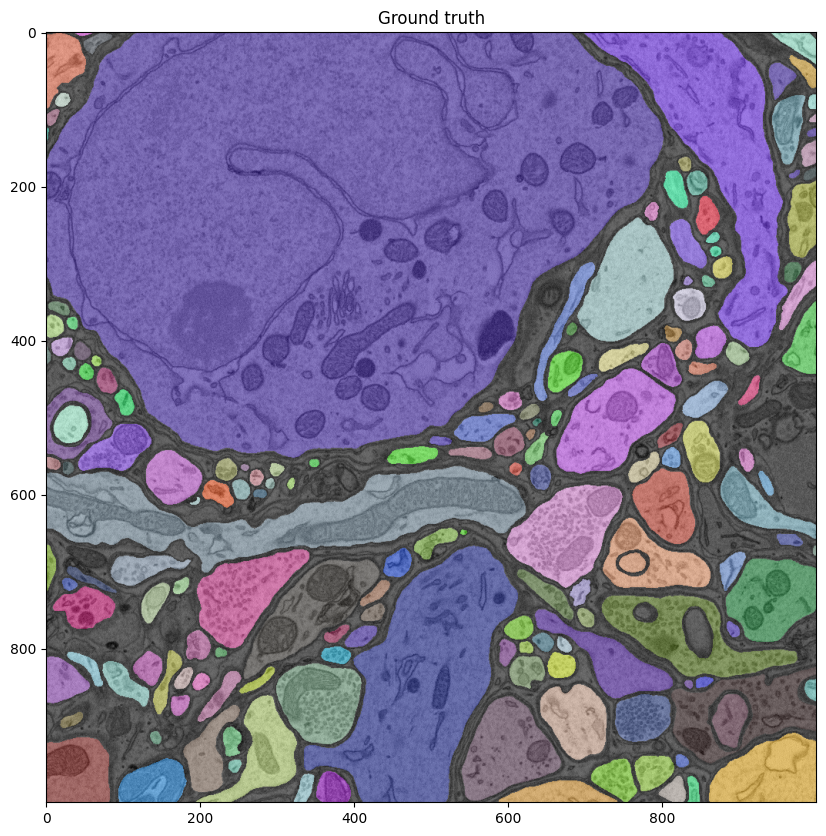

In [95]:
# Display data volume
layer = 99
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=True, sharey=True, squeeze=False)
raw_layer = raw[layer, :]
labels = gt[layer, :]

axes[0][0].imshow(raw_layer, cmap='gray')
axes[0][0].imshow(create_lut(np.squeeze(labels)), alpha=0.5)
axes[0][0].set_title("Ground truth")